step1. import library

In [1]:
import shutil
import glob
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter, iirnotch

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.utils import shuffle, class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

from IPython.display import Image

from google.colab import drive

step1-1.폴더 저장 경로 생성

In [2]:
submission_root = 'Team2_AI_ME_Submission'
if os.path.exists(submission_root):
    shutil.rmtree(submission_root)

os.makedirs(f'{submission_root}/code', exist_ok=True)
os.makedirs(f'{submission_root}/data', exist_ok=True)
os.makedirs(f'{submission_root}/weights', exist_ok=True)

print(f" 폴더 생성 완료: {submission_root}/ 내부에 code, data, weights 폴더 생성")


history_folder = f'{submission_root}/code/history'
os.makedirs(history_folder, exist_ok=True)

extra_files = [
    '1D_CNN_251210_selecting_CNN_structure.ipynb',
    '1D_CNN_251206_MVC_ELU.ipynb',
    '1D_CNN_251206.ipynb'
]


for file_name in extra_files:
    source = f'/content/drive/MyDrive/Colab Notebooks/{file_name}'
    destination = f'{history_folder}/{file_name}'

    if os.path.exists(source):
        shutil.copy(source, destination)
        print(f" 복사 완료: {file_name}")
    else:
        print(f" 파일 없음(확인 필요): {file_name}")

print(f"history 폴더 정리 완료. (위치: {history_folder})")


 폴더 생성 완료: Team2_AI_ME_Submission/ 내부에 code, data, weights 폴더 생성
 복사 완료: 1D_CNN_251210_selecting_CNN_structure.ipynb
 복사 완료: 1D_CNN_251206_MVC_ELU.ipynb
 복사 완료: 1D_CNN_251206.ipynb
history 폴더 정리 완료. (위치: Team2_AI_ME_Submission/code/history)


step2. 경로 설정(google colab or local) 및 inbody data 불러오기

In [3]:
try:
    from google.colab import drive
    is_colab = True
except ImportError:
    is_colab = False

if is_colab:
    drive.mount('/content/drive')
    print(" Google Colab 환경 감지됨")

    base_path = '/content/drive/MyDrive/Colab Notebooks/'
    excel_path = base_path + 'inbody_data.xlsx'
    train_folder_path = base_path + 'sEMG_data/'
    test_folder_path = base_path + 'sEMG_data_test/'

else:
    print(" Local/제출 환경 감지됨 (상대 경로 사용)")

    base_path = '../data/'

    excel_path = os.path.join(base_path, 'inbody_data.xlsx')
    train_folder_path = base_path
    test_folder_path = base_path

print(f" 데이터 경로: {base_path}")


print(f"Loading InBody Data from: {excel_path}")
inbody_df = pd.read_excel(excel_path, header=1)

#inbody data processing
le = LabelEncoder()
inbody_df['gender_encoded'] = le.fit_transform(inbody_df['gender'].astype(str))


numeric_feats = ['weight', 'SMM', 'BFM']
scaler_inbody = StandardScaler()

inbody_scaled = scaler_inbody.fit_transform(inbody_df[numeric_feats])

inbody_final = pd.DataFrame(inbody_scaled, columns=numeric_feats)
inbody_final['gender'] = inbody_df['gender_encoded']
inbody_final['participant'] = inbody_df['participant']
inbody_stats = inbody_final.set_index('participant')

inbody_dict = inbody_stats.T.to_dict('list')

file_map_df = inbody_df[['Unnamed: 9', 'Unnamed: 10']].dropna()
file_to_participant = dict(zip(file_map_df['Unnamed: 10'], file_map_df['Unnamed: 9']))

print(" InBody Processing Complete.")
print(f"   - Mapped Files Count: {len(file_to_participant)}")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Google Colab 환경 감지됨
 데이터 경로: /content/drive/MyDrive/Colab Notebooks/
Loading InBody Data from: /content/drive/MyDrive/Colab Notebooks/inbody_data.xlsx
 InBody Processing Complete.
   - Mapped Files Count: 28


/tmp/ipython-input-2775921138.py:46: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  inbody_dict = inbody_stats.T.to_dict('list')


stepe2-1. 데이터 저장 코드 추가

In [4]:
if is_colab:
    print("--- [Colab] 데이터 제출 폴더로 복사 시작 ---")

    shutil.copy(excel_path, f'{submission_root}/data/inbody_data.xlsx')

    train_files = glob.glob(train_folder_path + 'sEMG_data_*.csv')
    test_files = glob.glob(test_folder_path + 'sEMG_data_*.csv')

    print(f"--- 복사 시작 (Train: {len(train_files)}개, Test: {len(test_files)}개) ---")

    for f in train_files:
        shutil.copy(f, f'{submission_root}/data/')

    for f in test_files:
        shutil.copy(f, f'{submission_root}/data/')

    print(" Data 파일 복사 완료 (submission/data 폴더 확인)")
else:
    print("--- [Local] 데이터 복사 건너뜀 (이미 로컬에 존재) ---")




--- [Colab] 데이터 제출 폴더로 복사 시작 ---
--- 복사 시작 (Train: 25개, Test: 3개) ---
 Data 파일 복사 완료 (submission/data 폴더 확인)


step3. sEMG 데이터 로드 및 필터링

In [5]:
all_train_files = glob.glob(train_folder_path + 'sEMG_data_*.csv')
all_test_files = glob.glob(test_folder_path + 'sEMG_data_*.csv')
all_train_files.sort()
all_test_files.sort()

# defining filter functions
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if high >= 1.0: high = 0.99
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_semg_filters(data_array, fs=200):
    b_band, a_band = butter_bandpass(20, 95, fs, order=4)
    filtered_data = lfilter(b_band, a_band, data_array)
    b_notch, a_notch = iirnotch(w0=60, Q=30, fs=fs)
    filtered_data = lfilter(b_notch, a_notch, filtered_data)
    return filtered_data

def get_flatline_mask(series, window_size=20):
    is_flat = series.rolling(window=window_size).std().fillna(0) == 0
    is_small = series <= 6
    return is_flat | is_small

#Activating filtering fucntion
def process_and_filter_files(file_list, purpose="Train"):
    processed_list = []
    target_channels = ['Ch1', 'Ch2', 'Ch3', 'Ch4']

    print(f"--- Processing {purpose} Files ({len(file_list)} files) ---")

    for idx, f_path in enumerate(file_list):
        try:

            filename_full = os.path.basename(f_path)
            filename_key = os.path.splitext(filename_full)[0]

            df = pd.read_csv(f_path)
            df_filtered = df.copy()

            for ch in target_channels:
                raw_signal = df[ch].values
                filtered_signal = apply_semg_filters(raw_signal, fs=200)
                bad_mask = get_flatline_mask(df[ch], window_size=40)
                filtered_signal[bad_mask] = 0.0
                df_filtered[ch] = filtered_signal


            processed_list.append((df_filtered, filename_key))

            if idx == 0 or (idx + 1) % 10 == 0:
                print(f"[{idx+1}/{len(file_list)}] Done: {filename_key}")

        except Exception as e:
            print(f"Error processing {f_path}: {e}")

    return processed_list


# Do filtering
train_dfs_with_name = process_and_filter_files(all_train_files, purpose="Train")
test_dfs_with_name = process_and_filter_files(all_test_files, purpose="Test")


--- Processing Train Files (25 files) ---
[1/25] Done: sEMG_data_0
[10/25] Done: sEMG_data_17
[20/25] Done: sEMG_data_4
--- Processing Test Files (3 files) ---
[1/3] Done: sEMG_data_25


step4. Normalization (MVC, MinMax, Zscore)

In [6]:
target_channels = ['Ch1', 'Ch2', 'Ch3', 'Ch4']
SCALER_TYPE = 'Zscore'


train_dfs_only = [item[0] for item in train_dfs_with_name]
all_train_values = np.concatenate([df[target_channels].values for df in train_dfs_only])

if SCALER_TYPE == 'Zscore':
    scaler = StandardScaler()
    scaler.fit(all_train_values)
    def apply_normalization(data_values, scaler_obj):
        return scaler_obj.transform(data_values)

elif SCALER_TYPE == 'MVC':
    mvc_values = np.max(np.abs(all_train_values), axis=0) + 1e-8
    scaler = mvc_values
    def apply_normalization(data_values, scaler_obj):
        return data_values / scaler_obj

print(" Scaler fitted on Train Data.")



 Scaler fitted on Train Data.


step4-1. Scaler 저장

In [7]:
import joblib
joblib.dump(scaler, f'{submission_root}/weights/scaler.pkl')
print(" Scaler 저장 완료: scaler.pkl")


 Scaler 저장 완료: scaler.pkl


step5.Windowing

In [8]:
def create_windows_exclude_lv5(processed_data_list, scaler_obj, inbody_dict, file_to_participant, window_size=40, overlap=20):
    X_time_list = []
    X_inbody_list = []
    y_list = []
    step = window_size - overlap

    for (df, filename_key) in processed_data_list:
        raw_vals = df[target_channels].values
        data_norm = apply_normalization(raw_vals, scaler_obj)
        labels = df['label'].values

        p_id = file_to_participant.get(filename_key)
        if p_id is None or p_id not in inbody_dict: continue
        inbody_feat = inbody_dict[p_id]

        if len(data_norm) < window_size: continue

        for i in range(0, len(data_norm) - window_size + 1, step):
            window_label = labels[i + window_size - 1]


            if window_label == 5:
                continue


            window_data = data_norm[i : i + window_size]
            X_time_list.append(window_data)


            y_list.append(window_label)
            X_inbody_list.append(inbody_feat)

    return np.array(X_time_list), np.array(X_inbody_list), np.array(y_list)


print("Creating Datasets (Excluding Lv5)...")
X_train_time, X_train_inbody, y_train = create_windows_exclude_lv5(train_dfs_with_name, scaler, inbody_dict, file_to_participant)
X_test_time, X_test_inbody, y_test = create_windows_exclude_lv5(test_dfs_with_name, scaler, inbody_dict, file_to_participant)


y_train = y_train - 1
y_test = y_test - 1

print(f"Train Shape: {X_train_time.shape}")
print(f"Unique Labels in Train: {np.unique(y_train)}")

Creating Datasets (Excluding Lv5)...
Train Shape: (14079, 40, 4)
Unique Labels in Train: [0 1 2 3]


step6. AI model formation (+ Concatenate)

In [9]:
# Input
input_time = Input(shape=(40, 4), name='Time_Input')

# InBody Input (4 features)
input_inbody = Input(shape=(X_train_inbody.shape[1],), name='InBody_Input')


#  CNN Layers
x1 = Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.001), padding='same')(input_time)
x1 = BatchNormalization()(x1)
x1 = MaxPooling1D(2)(x1)
x1 = Dropout(0.4)(x1) # 0.3 -> 0.4

x1 = Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.0001), padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling1D(2)(x1)
x1 = Dropout(0.4)(x1) # 0.3 -> 0.4

x1 = Flatten()(x1)

# Dense Layers

x1 = Dense(128, activation='relu', kernel_regularizer=l2(0.0001), name='Dense_128')(x1)  # ,kernel_regularizer=l2(0.001)
x1 = Dropout(0.5)(x1) # 0.3 -> 0.5

x1 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='Dense_64')(x1)  # ,kernel_regularizer=l2(0.001)
x1 = Dropout(0.3)(x1)

x1 = Dense(16, activation='relu', kernel_regularizer=l2(0.0001), name='Dense_16')(x1)
x1 = Dropout(0.1)(x1)


# Concatenate
combined = Concatenate(name='Concat_Layer')([x1, input_inbody])

# Output Layer
output = Dense(4, activation='softmax', name='Final_Output')(combined)

# model compile
model = Model(inputs=[input_time, input_inbody], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Time_Input          │ (None, 40, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 40, 64)    │        832 │ Time_Input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 40, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 20, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20, 64)    │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 20, 128)   │     24,704 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 10, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 128)   │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1280)      │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_128 (Dense)   │ (None, 128)       │    163,968 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ Dense_128[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_64 (Dense)    │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ Dense_64[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_16 (Dense)    │ (None, 16)        │      1,040 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 16)        │          0 │ Dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InBody_Input        │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concat_Layer        │ (None, 20)        │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ InBody_Input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Final_Output        │ (None, 4)         │         84 │ Concat_Layer[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 199,652 (779.89 KB)

 Trainable params: 199,268 (778.39 KB)

 Non-trainable params: 384 (1.50 KB)

step7. training

In [10]:
# Class Weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

#eearly_stopping + Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

X_train_time, X_train_inbody, y_train = shuffle(X_train_time, X_train_inbody, y_train, random_state=42)

#training
history = model.fit(
    x=[X_train_time, X_train_inbody],
    y=y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict,
    verbose=1
)



Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.2399 - loss: 1.9147 - val_accuracy: 0.2500 - val_loss: 1.5161 - learning_rate: 5.0000e-04
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2429 - loss: 1.5388 - val_accuracy: 0.2543 - val_loss: 1.4600 - learning_rate: 5.0000e-04
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2428 - loss: 1.4734 - val_accuracy: 0.2717 - val_loss: 1.4373 - learning_rate: 5.0000e-04
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2658 - loss: 1.4500 - val_accuracy: 0.2820 - val_loss: 1.4270 - learning_rate: 5.0000e-04
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2934 - loss: 1.4314 - val_accuracy: 0.3168 - val_loss: 1.4212 - learning_rate: 5.0000e-04
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3141 - loss: 1.4276 - val_accuracy: 0.3381 - val_loss: 1.4182 - learning_rate: 5.0000e-04
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - a

step7-1. Weights 저장

In [11]:
model_save_path = f'{submission_root}/weights/best_model.h5'
model.save(model_save_path)

print(f"모델 저장 완료: {model_save_path}")


모델 저장 완료: Team2_AI_ME_Submission/weights/best_model.h5


step8. evaluation

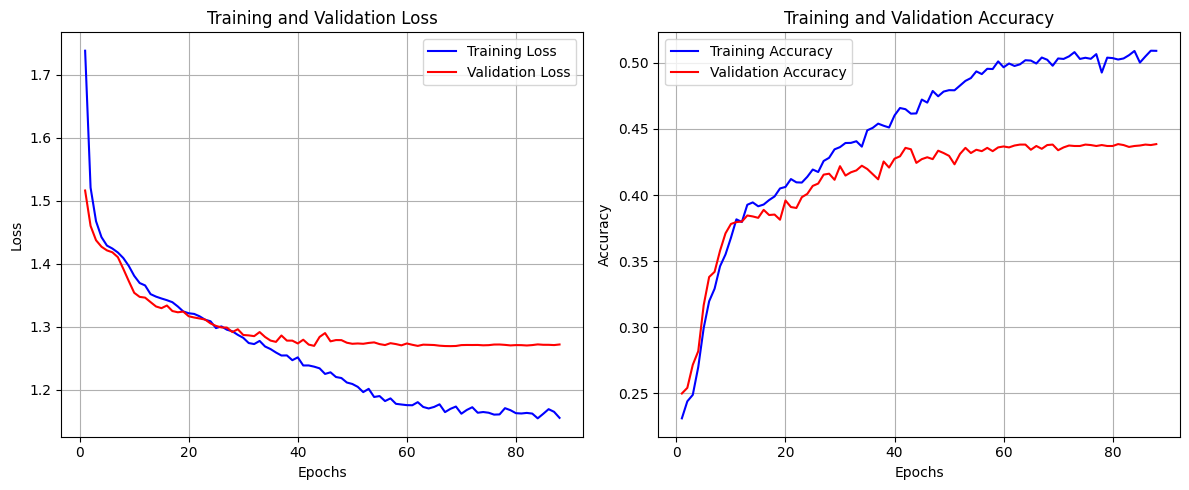

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


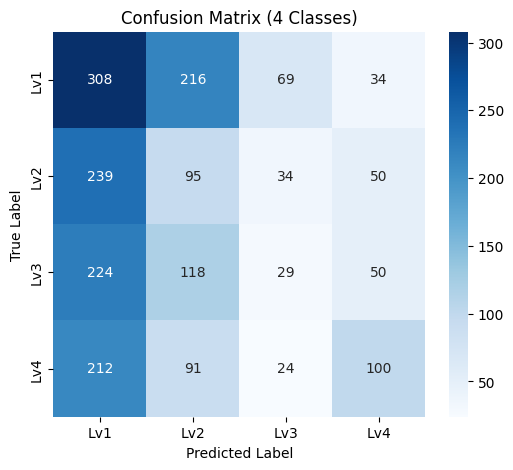

              precision    recall  f1-score   support

         Lv1       0.31      0.49      0.38       627
         Lv2       0.18      0.23      0.20       418
         Lv3       0.19      0.07      0.10       421
         Lv4       0.43      0.23      0.30       427

    accuracy                           0.28      1893
   macro avg       0.28      0.26      0.25      1893
weighted avg       0.28      0.28      0.26      1893



In [12]:
results_folder = f'{submission_root}/results'
os.makedirs(results_folder, exist_ok=True)



def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{results_folder}/learning_curve.png', dpi=300)
    plt.show()


if 'history' in globals():
    plot_training_history(history)
else:
    print("Error: 'history' variable not found. Train the model first.")




# Confusion Matrix
y_pred_probs = model.predict([X_test_time, X_test_inbody])
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Lv1','Lv2','Lv3','Lv4'],
            yticklabels=['Lv1','Lv2','Lv3','Lv4'])
plt.title('Confusion Matrix (4 Classes)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(f'{results_folder}/confusion_matrix.png', dpi=300)
plt.show()

# Report
print(classification_report(y_test, y_pred, target_names=['Lv1', 'Lv2', 'Lv3', 'Lv4']))


step9. 모델 구조도

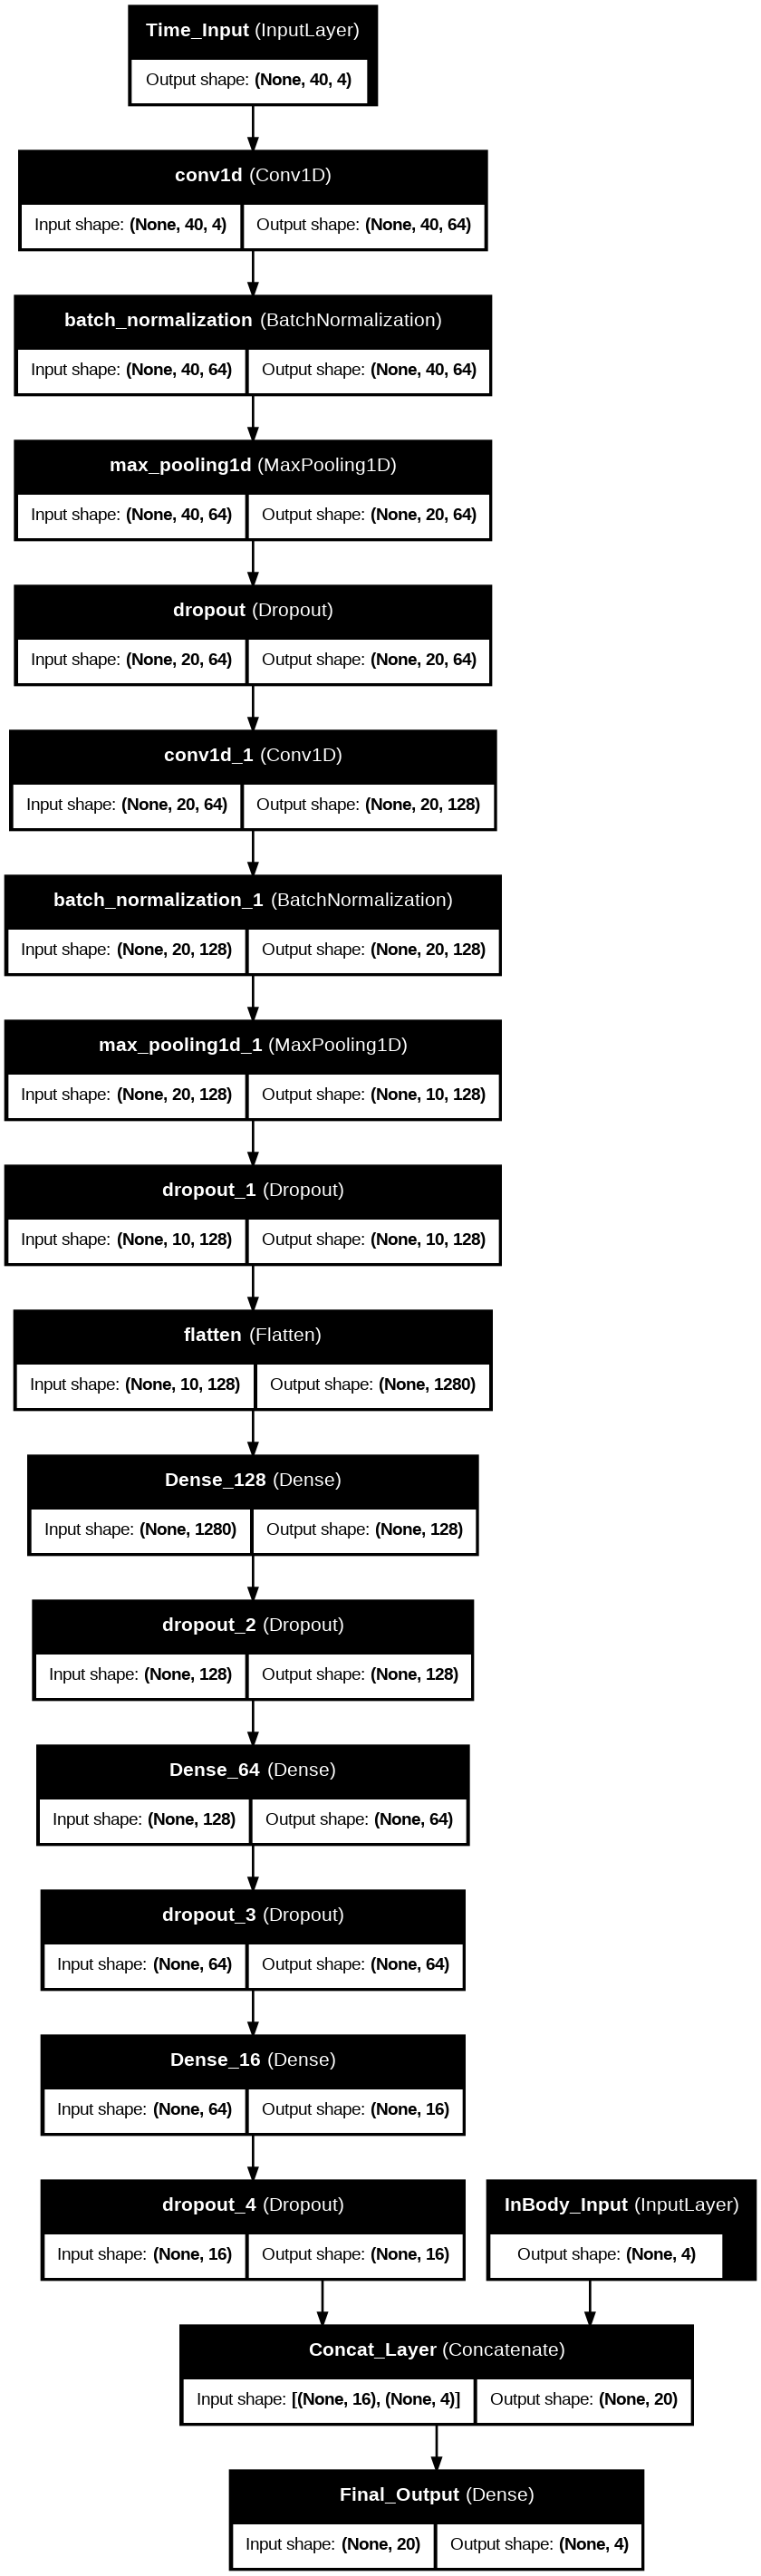

 모델 구조도 저장 완료: Team2_AI_ME_Submission/results/model_structure.png


In [13]:
plot_path = f'{submission_root}/results/model_structure.png'

plot_model(model,
           to_file=plot_path,
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB',
           dpi=96)

display(Image(plot_path))
print(f" 모델 구조도 저장 완료: {plot_path}")



step10. Downloading Zip file

In [14]:
with open(f'{submission_root}/code/README_code.txt', 'w') as f:
    f.write("Google Colab에서 작성된 코드입니다.\n")
    f.write("자세한 내용은 제출된 .ipynb 파일이나 보고서를 참고해주세요.\n")

shutil.make_archive(submission_root, 'zip', submission_root)

from google.colab import files
files.download(f'{submission_root}.zip')

print(f" 1. {submission_root}.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 1. Team2_AI_ME_Submission.zip
